# Quantifying Crowded Trades(QCT): A Comprehensive Analysis
### asset_centrality
### Collins Emezie Ugwuozor, Jayesh Chandra Gupta, Emmanuel Effiong Asuquo

In [1]:
#Import the neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_datareader import data
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
import requests
from bs4 import BeautifulSoup

In [2]:
# Pick up table of S&P 500 listed companies from Wikipedia.
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [3]:
table = data[0]
table.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
table['GICS Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Staples', 'Utilities', 'Financials',
       'Consumer Discretionary', 'Materials', 'Real Estate',
       'Communication Services', 'Energy'], dtype=object)

In [5]:
# Select sectors of S&P 500
industrials_sector = table[table['GICS Sector'] == 'Industrials'] # XLI
health_sector = table[table['GICS Sector'] == 'Health Care'] # XLV
tech_sector = table[table['GICS Sector'] == 'Information Technology'] # XLK
consumer_staples_sector = table[table['GICS Sector'] == 'Consumer Staples'] # XLP
utilities_sector = table[table['GICS Sector'] == 'Utilities'] # XLU
financial_sector = table[table['GICS Sector'] == 'Financials'] # XLF
consumer_discretionary_sector = table[table['GICS Sector'] == 'Consumer Discretionary'] # XLY
materials_sector = table[table['GICS Sector'] == 'Materials'] # XLB
real_estate_sector = table[table['GICS Sector'] == 'Real Estate'] # XLRE
communication_services_sector = table[table['GICS Sector'] == 'Communication Services'] # XLC *XTL
energy_sector = table[table['GICS Sector'] == 'Energy'] # XLE

In [6]:
# Define dates for five year historical prices
start_date = "2018-01-01"
end_date = "2023-01-01"

In [7]:
# Get financial assets and tech assets
financial_assets = financial_sector['Symbol'].tolist()
tech_assets = tech_sector['Symbol'].tolist()
print(financial_assets)
print(tech_assets)

['AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'ACGL', 'AJG', 'AIZ', 'BAC', 'WRB', 'BRK.B', 'BLK', 'BX', 'BK', 'BRO', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'EG', 'FDS', 'FITB', 'FIS', 'FI', 'FLT', 'BEN', 'GL', 'GPN', 'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JKHY', 'JPM', 'KEY', 'L', 'MTB', 'MKTX', 'MMC', 'MA', 'MET', 'MCO', 'MS', 'MSCI', 'NDAQ', 'NTRS', 'PYPL', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'SYF', 'TROW', 'TRV', 'TFC', 'USB', 'V', 'WFC', 'WTW', 'ZION']
['ACN', 'ADBE', 'AKAM', 'AMD', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK', 'AVGO', 'CDNS', 'CDW', 'CSCO', 'CTSH', 'GLW', 'ENPH', 'EPAM', 'FFIV', 'FICO', 'FSLR', 'FTNT', 'IT', 'GEN', 'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MCHP', 'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NVDA', 'NXPI', 'ON', 'ORCL', 'PANW', 'PTC', 'QRVO', 'QCOM', 'ROP', 'CRM', 'STX', 'NOW', 'SWKS', 'SEDG', 'SNPS', 'TEL', 'TDY', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN', 'WDC', 'ZBRA']


In [8]:
# Get the  "Adj Close" data from Yahoo Finance
def get_asset_data (asset_data, start, end):
  df_asset = yf.download(asset_data, start=start_date, end=end_date)['Adj Close']

  # Select the Top 10 assets based on ROI
  roi = (df_asset.iloc[-1] - df_asset.iloc[0])/ df_asset.iloc[0]
  top_10_ROI = roi.sort_values(ascending = False).head(10)
  roi_tickers = top_10_ROI.index.tolist()
  # Get the  "Adj Close" data of top 10 from Yahoo Finance
  df_prices = yf.download(roi_tickers, start=start_date, end=end_date)['Adj Close']
  # Calculate daily returns for Top ROI Stocks
  df_assets= df_prices.pct_change().dropna()
  return df_assets

In [9]:
# Assets across tech and finance sector
df_financial_assets =get_asset_data (financial_assets, start=start_date, end=end_date)
df_tech_assets = get_asset_data (tech_assets, start=start_date, end=end_date)

[*********************100%%**********************]  72 of 72 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  64 of 64 completed
[*********************100%%**********************]  10 of 10 completed


In [10]:
# Standardize the data and calculate covariance matrix of financial assets ad tech assets
scaler = StandardScaler()
financial_assets_scaled = scaler.fit_transform(df_financial_assets)
financial_assets_cov = np.cov(financial_assets_scaled.T)

df_financial_assets.head()

,AJG,AON,BRO,BX,MA,MMC,MSCI,NDAQ,PGR,WRB
Date,,,,,,,,,,
2018-01-03,0.007560,0.015971,0.011355,0.014760,0.012573,0.013060,0.015194,0.011989,-0.000542,-0.008281
2018-01-04,0.009259,0.013699,0.002710,0.007879,0.012937,0.010436,0.015738,0.013263,-0.000181,0.004031
2018-01-05,0.004587,0.008492,0.009459,-0.007517,0.020730,0.006926,0.010406,0.006608,0.003796,-0.004158
2018-01-08,0.000630,0.000073,-0.003059,0.008179,0.003023,-0.010619,0.001353,0.009469,0.003062,-0.005040
2018-01-09,0.001259,0.002489,0.008057,0.013822,0.001444,0.000000,0.006681,0.002626,0.008438,-0.004486


In [11]:
tech_assets_scaled = scaler.fit_transform(df_tech_assets)
tech_assets_cov = np.cov(tech_assets_scaled.T)

df_tech_assets.head(10)

,AAPL,AMD,CDNS,ENPH,FICO,FTNT,KEYS,KLAC,SEDG,SNPS
Date,,,,,,,,,,
2018-01-03,-0.000174,0.051913,0.020927,-0.007692,0.000261,0.015333,0.014235,0.011684,0.026281,0.011973
2018-01-04,0.004645,0.049351,0.015141,-0.031008,0.011406,-0.022874,0.004912,0.001770,-0.043534,0.009534
2018-01-05,0.011385,-0.019802,0.009408,-0.012000,0.011213,0.002273,0.022346,0.021384,0.014726,0.011833
2018-01-08,-0.003715,0.033670,0.021141,-0.024291,0.012363,0.020408,0.014800,0.002730,0.011873,0.009333
2018-01-09,-0.000115,-0.037459,0.003339,-0.012448,-0.003147,-0.015111,0.013013,-0.008715,-0.029987,-0.000780
2018-01-10,-0.000230,0.011844,-0.005103,-0.050420,-0.000884,-0.004964,-0.017940,-0.026740,-0.016129,-0.003902
2018-01-11,0.005680,0.015050,0.000669,0.061947,0.012830,0.003628,0.013081,-0.000376,0.024590,0.004142
2018-01-12,0.010326,-0.009885,0.004457,-0.066667,-0.004306,0.015364,-0.002226,0.009883,-0.032000,0.007357
2018-01-16,-0.005082,-0.009151,-0.017528,-0.066964,0.001191,-0.013351,-0.001562,0.003449,-0.017906,-0.012172


#### Step 1: Calculate Asset Centrality For Financial Assets

## Absorbtion Ratio $$AR = \frac{\sum_{i=1}^n \sigma^2E_i}{\sum_{j=1}^N \sigma^2A_j}$$

- $N$ = number of assets
- $n$ = number of eigenvectors
- $\sigma^2E_i$ = variance of the $i^{th}$ eigenvector
- $\sigma^2A_j$ = variance of the $j^{th}$ asset

The fraction of the total variance that is "absorbed"/explained by a fixed number of eigenvectors

We will Calculate the Absorbsion Ratio(AR) for Assets using:
- PCA
- Eigen decomposition of Covariance matrix
- Eigen values and sum of variance of original data

The absorption ratio:
- Measures the degree of concentration within a set of assets.
- Represents the portion of variability in asset returns that can be attributed to a specific number of factors in a Principal Component Analysis (PCA).
- When elevated, indicates a propensity for shocks to rapidly disseminate across a wide spectrum.

In [12]:
# AR calculation using PCA
n = 2
sectors_pca = PCA(n_components=n)
sectors_pca.fit(df_financial_assets)
ar_pca = np.sum(sectors_pca.explained_variance_ratio_)
print(f'The percent of explained variance in the first {n} principal components = {ar_pca}')

# AR calculation using eigen decompostion of covariance matrix
w, v = np.linalg.eig(financial_assets_cov)
sorted_eigenvalues = w.argsort()[::-1]
var_ratio = [eig/np.sum(w) for eig in w[sorted_eigenvalues]]
print(f'The percent of explained variance in the first {n} eigen vectors = {np.sum(var_ratio[0:2])}')

# AR calculation using eigen values and sum of variances of original data
ar_num = np.sum(w[sorted_eigenvalues][0:n])
ar_denom = np.sum(np.var(financial_assets_scaled, axis=0))
ar = ar_num/ar_denom
print(f'The absorbtion ratio of the first {n} eigen vectors over original X variance = {ar}')

The percent of explained variance in the first 2 principal components = 0.7281315834887545
The percent of explained variance in the first 2 eigen vectors = 0.7219445315496373
The absorbtion ratio of the first 2 eigen vectors over original X variance = 0.7225188708746568


## Centrality  $$C_i = \frac {\sum_{j=1}^n \biggl( AR^j  \frac{| EV_i^j |}{\sum_{k=1}^N | EV_k^j |} \biggr)}{\sum_{j=1}^n AR^j} $$

- $C_i$ = asset's centrality score
- $AR^j$ = absorbtion ratio of the $j^th$ eigenvector
- $EV_i^j$ = absolute value of the exposure of the $i^th$ sector within the $j^th$ eigenvector
- $n$ = number of eigenvectors in the numerator of the absorbtion ratio
- $N$ = total number of assets

In [13]:
def centrality_score(X, n=2):
    N = X.shape[1]
    pca_model = PCA(n_components=n)
    pca_model.fit(X)
    EV = pca_model.components_
    AR = pca_model.explained_variance_ratio_
    C_list = []
    for i in range(N):
        C_num = []
        C_denom = []
        for j in range(n):
            C_num.append(AR[j] * \
                    (abs(EV[j][i])/\
                     sum([abs(EV[j][k]) for k in range(N)])))
            C_denom.append(AR[j])

        C_list.append(sum(C_num)/sum(C_denom))
    return C_list

To assess asset centrality, we will follow these steps:
- Gather five years of historical daily returns for individual assets.
- Assign weights to each historical return based on the square root of their respective market capitalization weights.
- Calculate the covariance matrix of the assets.
- Determine the asset centrality using the top two eigenvectors.


In [14]:
df_financial_assets.columns.to_list()

['AJG', 'AON', 'BRO', 'BX', 'MA', 'MMC', 'MSCI', 'NDAQ', 'PGR', 'WRB']

In [15]:
# Getting quote data from yahoo finance
tickers= df_financial_assets.columns.to_list()
market_cap=[]
for ticker in tickers:
    print(ticker)
    try:
        market_cap.append(data.get_quote_yahoo(ticker)['marketCap'])
    except:
        print('Yahoo Finance quote error with: ', ticker)

AJG
Yahoo Finace quote error with:  AJG
AON
Yahoo Finace quote error with:  AON
BRO
Yahoo Finace quote error with:  BRO
BX
Yahoo Finace quote error with:  BX
MA
Yahoo Finace quote error with:  MA
MMC
Yahoo Finace quote error with:  MMC
MSCI
Yahoo Finace quote error with:  MSCI
NDAQ
Yahoo Finace quote error with:  NDAQ
PGR
Yahoo Finace quote error with:  PGR
WRB
Yahoo Finace quote error with:  WRB


In [16]:
# Asset's Mkt Cap (USD m) picked manually From bloomberg
market_cap = [53601,66880,20733,119308,369840,98836,40673,30066,93835,17574]

In [17]:
weights=[]
for i in range(10):
    weights.append(market_cap[i]/(np.array(market_cap)).sum())
weights

[0.0588152030074198,
 0.07338595879062398,
 0.022749866680711828,
 0.13091405459616876,
 0.40581732953236205,
 0.1084505774974598,
 0.04462959183449535,
 0.03299076311302184,
 0.10296308975954248,
 0.019283565188194164]

In [18]:
# multiply the returns by the square root of market weights of each asset
weights = np.array([.059, .073, .023, .131, .406, .108, .045, .033, .103, .019])
asset_weights = dict(zip(df_financial_assets.columns, weights*100))
weighted_df = df_financial_assets.copy()
for asset in df_financial_assets.columns:
    weighted_df.loc[:,asset] = weighted_df.loc[:, asset] * asset_weights[asset]**.5
weighted_df.head()

,AJG,AON,BRO,BX,MA,MMC,MSCI,NDAQ,PGR,WRB
Date,,,,,,,,,,
2018-01-03,0.018363,0.043150,0.017221,0.053422,0.080115,0.042918,0.032232,0.021778,-0.001739,-0.011415
2018-01-04,0.022491,0.037012,0.004110,0.028518,0.082434,0.034296,0.033386,0.024093,-0.000580,0.005557
2018-01-05,0.011142,0.022945,0.014346,-0.027206,0.132089,0.022760,0.022074,0.012004,0.012183,-0.005732
2018-01-08,0.001529,0.000198,-0.004640,0.029604,0.019261,-0.034897,0.002870,0.017201,0.009826,-0.006946
2018-01-09,0.003058,0.006726,0.012219,0.050028,0.009202,0.000000,0.014173,0.004771,0.027081,-0.006184


In [19]:
print(f'Not scaled - {sorted(zip(tickers,[np.around(C,3) for C in centrality_score(df_financial_assets)]), key=lambda x: x[1], reverse=True)}')

unscaled_scores = dict(zip(tickers, [np.around(C,3) for C in centrality_score(df_financial_assets)]))

Not scaled - [('BX', 0.149), ('MSCI', 0.122), ('MA', 0.108), ('AJG', 0.096), ('BRO', 0.096), ('WRB', 0.093), ('AON', 0.088), ('MMC', 0.086), ('NDAQ', 0.082), ('PGR', 0.078)]


In [20]:
print(f'Scaled - {sorted(zip(tickers,[np.around(C,3) for C in centrality_score(financial_assets_scaled)]), key=lambda x: x[1], reverse=True)}')

scaled_scores = dict(zip(tickers, [np.around(C,3) for C in centrality_score(financial_assets_scaled)]))

Scaled - [('AJG', 0.109), ('BRO', 0.107), ('MMC', 0.105), ('MSCI', 0.103), ('BX', 0.1), ('MA', 0.1), ('NDAQ', 0.098), ('AON', 0.097), ('WRB', 0.095), ('PGR', 0.087)]


In [21]:
print(f'Weighted - {sorted(zip(tickers,[np.around(C,3) for C in centrality_score(weighted_df)]), key=lambda x: x[1], reverse=True)}')

weighted_scores = dict(zip(tickers, [np.around(C,3) for C in centrality_score(weighted_df)]))

Weighted - [('MA', 0.3), ('BX', 0.19), ('MMC', 0.086), ('MSCI', 0.083), ('AON', 0.072), ('PGR', 0.071), ('AJG', 0.066), ('NDAQ', 0.053), ('BRO', 0.043), ('WRB', 0.036)]


In [22]:
# Create a dataframe of scores computed from different methods
for asset in unscaled_scores:
    unscaled_scores[asset] = [unscaled_scores[asset], scaled_scores[asset], weighted_scores[asset]]
scores_df = pd.DataFrame(data=unscaled_scores, index=['Unscaled', 'Scaled', 'Weighted'])
scores_df

,AJG,AON,BRO,BX,MA,MMC,MSCI,NDAQ,PGR,WRB
Unscaled,0.096,0.088,0.096,0.149,0.108,0.086,0.122,0.082,0.078,0.093
Scaled,0.109,0.097,0.107,0.100,0.100,0.105,0.103,0.098,0.087,0.095
Weighted,0.066,0.072,0.043,0.190,0.300,0.086,0.083,0.053,0.071,0.036


In [23]:
# rolling 1-year centrality score
rolling_Cs = [centrality_score(weighted_df.iloc[i-252:i,:]) for i in range(252, weighted_df.shape[0]+1)]

<Axes: title={'center': 'Financial Assets 1-year Rolling Centrality Score'}>

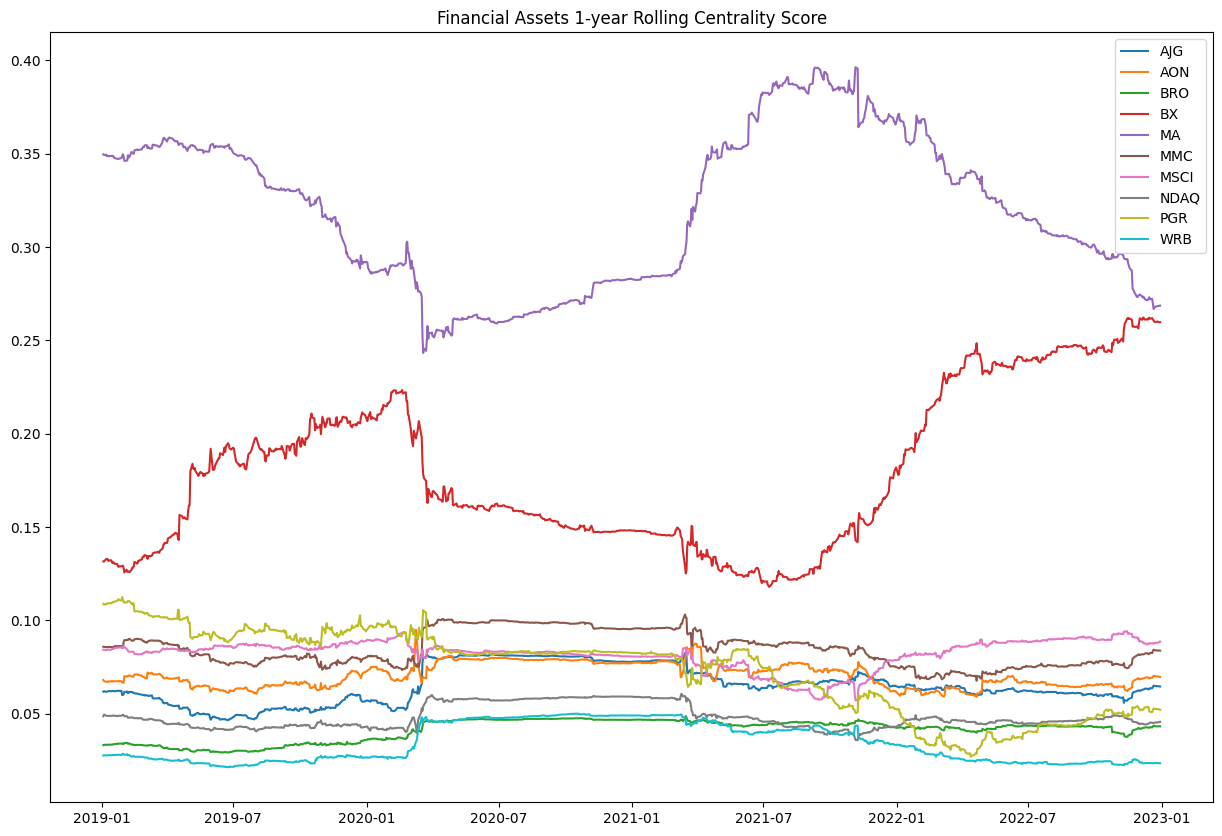

In [24]:
pd.DataFrame(data=rolling_Cs, columns=df_financial_assets.columns, index=[date.date() for date in df_financial_assets.index[251:]]).plot(figsize=(15,10), title='Financial Assets 1-year Rolling Centrality Score')